In [0]:
%tensorflow_version 2.x
import tensorflow as tf
device = tf.test.gpu_device_name()
if device != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device))

from google.colab import drive
drive.mount('/content/drive')


%cd /content/drive/My Drive/Colab Notebooks
# RMS prop run again to get less std. 

In [0]:
# Importing Libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import argparse, copy

from model import *
from utils import *
from measures import *

In [0]:
seed = 12345
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Hyperparamters
batch_size = 64 
epochs = 22
lrs = [3e-2, 3e-3, 3e-4, 3e-5, 3e-6]  
gamma = 0.7
momentum = 0.9

use_cuda = torch.cuda.is_available()
train_loader, val_loader, test_loader, train_size, val_size = dataloaders(batch_size, use_cuda, seed)
print (train_size, val_size, len(test_loader.dataset))

model = Net().to(device)
# num_val_examples = 6000

54000 6000 10000


In [0]:
# Grid Search over different learning rates - over validation dataset
val_losses = []
for lr in lrs:
    print ("lr:", lr)
    model_copy = copy.deepcopy(model)
    optimizer = optim.RMSprop(model_copy.parameters(), lr=lr, momentum=momentum)
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

    for epoch in range(1, epochs + 1):
        train_loss = train(model_copy, device, train_loader, optimizer, epoch, batch_size)
        val_loss = test_2(model_copy, device, val_loader, batch_size, val_size)
        # test_loss = test(model_copy, device, test_loader, batch_size)  # one can see on test_loss as well.....
        scheduler.step()
    val_losses.append(val_loss)
print ("Validation Losses::\n", val_losses)        


'best lr = 3e-6 in case of RMSprop'

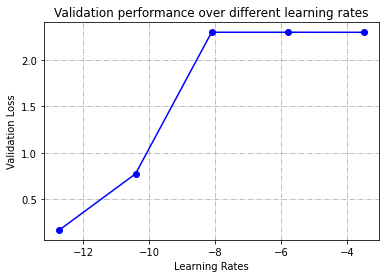

In [0]:
# Learning Rates - ['3e-2', '3e-3', '3e-4', '3e-5', '3e-6'] plotted on log scale
lr_rates = np.log(np.array(lrs))
fig = plt.figure()
plt.plot(lr_rates, val_losses, color='blue', marker='o') 
plt.xlabel('Learning Rates')
plt.ylabel('Validation Loss')
plt.title("Validation performance over different learning rates")
plt.grid(True, linestyle='-.')
fig.show()   
# plt.legend(['3e-2', '3e-3', '3e-4', '3e-5', '3e-6'], loc='upper right')
"""best lr = 3e-6 in case of RMSprop"""


Test set: Average loss: 0.6932, Accuracy: 7525/10000 (75%)


Test set: Average loss: 0.6466, Accuracy: 7638/10000 (76%)


Test set: Average loss: 0.6223, Accuracy: 7674/10000 (77%)


Test set: Average loss: 0.6134, Accuracy: 7706/10000 (77%)


Test set: Average loss: 0.6045, Accuracy: 7718/10000 (77%)


Test set: Average loss: 0.6021, Accuracy: 7724/10000 (77%)


Test set: Average loss: 0.5955, Accuracy: 7726/10000 (77%)


Test set: Average loss: 0.5953, Accuracy: 7732/10000 (77%)


Test set: Average loss: 0.5929, Accuracy: 7734/10000 (77%)


Test set: Average loss: 0.5930, Accuracy: 7734/10000 (77%)


Test set: Average loss: 0.5932, Accuracy: 7733/10000 (77%)


Test set: Average loss: 0.5899, Accuracy: 7735/10000 (77%)


Test set: Average loss: 0.5927, Accuracy: 7734/10000 (77%)


Test set: Average loss: 0.5917, Accuracy: 7735/10000 (77%)


Test set: Average loss: 0.5911, Accuracy: 7737/10000 (77%)


Test set: Average loss: 0.5931, Accuracy: 7736/10000 (77%)


Test set: Average loss:

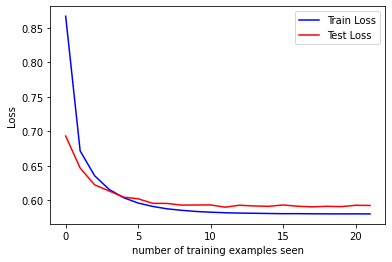

In [0]:
train_losses, test_losses = [], []
lr = 3e-6 # good one - lowest validation loss among others
sigmas = [0.001,0.003,0.006,0.009,0.03,0.06,0.09]    
delta = 1e-2
mean = 0.0

weight_norms_list = []
sharpness_list = []

optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=momentum)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch, batch_size)
    train_losses.append(train_loss)
    test_loss = test(model, device, test_loader, batch_size)
    test_losses.append(test_loss)
    scheduler.step()
    
show_losses(train_losses, test_losses)

In [0]:
# print train and test losses and their difference
diff_test_train = np.array(test_losses)  - np.array(train_losses)
print ("diff_test_train::\n", diff_test_train)

diff_test_train::
 [-0.17388522 -0.02487513 -0.01319008 -0.00228534  0.00085315  0.00611789
  0.00452442  0.00781684  0.00756124  0.0093749   0.01054103  0.00808784
  0.01140532  0.01061047  0.01039315  0.01265117  0.01077162  0.01004177
  0.01094902  0.01055888  0.01244179  0.01227637]


In [0]:
"""run for each sigma"""
std_list = []
mean_list = []

for sigma in sigmas:
    weight_l2_norm = cal_l2_norm(model)
    weight_bound = compute_bound(model, train_size, sigma, weight_l2_norm, delta)  
    weight_norms_list.append(weight_bound)
    # print ("norm bound:::", weight_bound)

    #to calculate sharpness, perturb the same model 10 times, then get expected value
    num_times = 10
    p_train_losses = []
    for iterate in range(num_times):
        p_model = copy.deepcopy(model)
        p_model = weight_pertubation(p_model, mean, sigma, device)
        p_train_loss = test_2(p_model, device, train_loader, batch_size, train_size)
        p_train_losses.append(p_train_loss)
    exp_p_error = sum(p_train_losses) / len(p_train_losses)
    std_list.append(np.std(np.array(p_train_losses)))
    mean_list.append(np.mean(np.array(p_train_losses)))

    sharpness = exp_p_error - train_loss
    # print ("sharpness:::", sharpness)
    sharpness_list.append(sharpness)


Test set: Average loss: 0.5805, Accuracy: 42038/54000 (78%)


Test set: Average loss: 0.5803, Accuracy: 42052/54000 (78%)


Test set: Average loss: 0.5804, Accuracy: 42045/54000 (78%)


Test set: Average loss: 0.5802, Accuracy: 42037/54000 (78%)


Test set: Average loss: 0.5804, Accuracy: 42042/54000 (78%)


Test set: Average loss: 0.5803, Accuracy: 42040/54000 (78%)


Test set: Average loss: 0.5804, Accuracy: 42038/54000 (78%)


Test set: Average loss: 0.5803, Accuracy: 42053/54000 (78%)


Test set: Average loss: 0.5802, Accuracy: 42039/54000 (78%)


Test set: Average loss: 0.5804, Accuracy: 42040/54000 (78%)


Test set: Average loss: 0.5815, Accuracy: 42044/54000 (78%)


Test set: Average loss: 0.5818, Accuracy: 42021/54000 (78%)


Test set: Average loss: 0.5817, Accuracy: 42025/54000 (78%)


Test set: Average loss: 0.5819, Accuracy: 42024/54000 (78%)


Test set: Average loss: 0.5820, Accuracy: 42040/54000 (78%)


Test set: Average loss: 0.5818, Accuracy: 42026/54000 (78%)


Test se

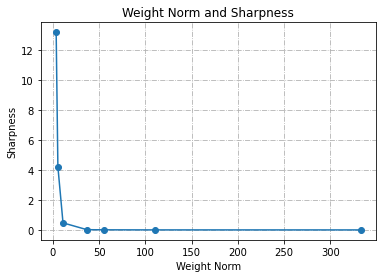

In [0]:
plt.plot(weight_norms_list, sharpness_list, marker='o')
plt.grid(True, linestyle='-.')
plt.title("Weight Norm and Sharpness")
plt.xlabel("Weight Norm")
plt.ylabel("Sharpness")
plt.show()
# plt.legend() #loc='lower left'

In [0]:
print ("sharpness_list::\n", sharpness_list)
print ("weight_norms_list::\n", weight_norms_list)
print ("std_list::\n", std_list)
print ("mean_list::\n", mean_list)	        

sharpness_list::
 [0.00021284886622596755, 0.0016814743208376504, 0.006880385859458937, 0.015957456933096137, 0.46940483973489544, 4.2137451043520215, 13.164678001619203]
weight_norms_list::
 [332.6109313964844, 110.87032318115234, 55.43519592285156, 36.95683288574219, 11.08724594116211, 5.543947696685791, 3.6963257789611816]
std_list::
 [7.42156353092892e-05, 0.00024108364579069878, 0.0008483152864840232, 0.0022661033898971786, 0.12228044108858009, 1.8368084177088548, 7.157748125893053]
mean_list::
 [0.5803221083771419, 0.5817907338317536, 0.5869896453703749, 0.5960667164440121, 1.0495140992458116, 4.793854363862938, 13.744787261130123]


In [0]:
print (p_train_losses)

[7.458006983684703, 8.542306732227452, 13.406519338417958, 12.297635734928727, 15.695537187476859, 8.37582063731424, 6.086579254170729, 28.51311896762577, 11.893970603626487, 25.178377171828284]


In [0]:
# train_losses, test_losses = [], []
# train_size = len(train_loader.dataset)
# lr = 3e-2 #3e-3
# var_gradients_list = []  

# optimizer = optim.Adagrad(model.parameters(), lr=lr)#, momentum=momentum)
# # optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=momentum)
# scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

# for epoch in range(1, epochs + 1):
#     train_loss, grad_norms, grad_avg = train(model, device, train_loader, optimizer, epoch, batch_size)
#     print ("train_loss::", train_loss)
#     train_losses.append(train_loss)
#     test_loss = test(model, device, test_loader, batch_size)
#     test_losses.append(test_loss)
#     scheduler.step()
    
#     # computing var_score over one epoch
#     variance_score = compute_grad_variance(grad_norms, grad_avg)
#     # print ("var score", variance_score)
#     var_gradients_list.append(variance_score)
    
# show_losses(train_losses, test_losses)